imports

In [1]:
!pip install torch

import pandas as pd
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42); np.random.seed(42)

# DONNEES

In [3]:
#chargement scénario déterministe
scenario_deterministe = pd.read_csv("../data/scenario_equiv.csv",sep=";", encoding="utf-8")
scenario_deterministe = scenario_deterministe.replace(',', '.', regex=True).astype(float)
scenario_deterministe.columns = scenario_deterministe.columns.str.replace(' ', '_')

In [4]:
#chargement scénarios GSE
data=pd.read_csv("../data/3000_scenariosSTO.csv",sep=";", encoding="utf-8")
data = data.replace(',', '.', regex=True).astype(float)
data.columns = data.columns.str.replace(' ', '_')

/tmp/ipykernel_66064/3391337921.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


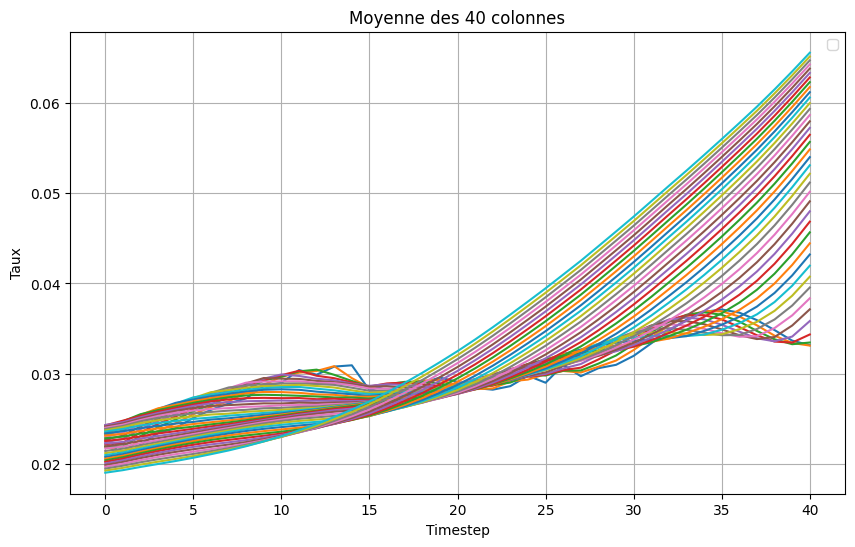

In [5]:
#tracé des scénarios GSE
spot_cols = [col for col in data.columns if 'EUR_Nom_Spot_' in col]
spot_cols = sorted(spot_cols, key=lambda x: int(x.split('_')[-1]))
spot_data = data[spot_cols].values  # shape (123000, 40)

data = spot_data.reshape((3000, 41, 40))  # 3000 scénarios, 41 time_steps, 40 maturités

mean_paths = np.mean(data, axis=0)

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Timestep')
plt.ylabel('Taux')
plt.legend()
plt.grid(True)
plt.show()

# PIGAN

In [6]:
M, T = 41, 40  # maturités, dates

class PerMaturityNormalizer:
    def fit(self, x_train: torch.Tensor):
        self.mean = x_train.mean(dim=(0,2), keepdim=True)             # (1, M, 1)
        self.std  = x_train.std(dim=(0,2), keepdim=True).clamp_min(1e-8)
        return self
    def transform(self, x):        return (x - self.mean) / self.std
    def inverse_transform(self, x):return x * self.std + self.mean

class ScenarioDataset(Dataset):
    def __init__(self, x_tensor: torch.Tensor):
        self.x = x_tensor.float()
    def __len__(self):  return self.x.size(0)
    def __getitem__(self, i): return self.x[i]

In [7]:
X_raw = torch.from_numpy(data).float()   # -> torch.Tensor (float32)
dataset_full = ScenarioDataset(X_raw)

# split train/val par scénarios
ratio = 0.8
n_train = int(len(dataset_full)*ratio)
n_val   = len(dataset_full) - n_train
train_raw, val_raw = random_split(dataset_full, [n_train, n_val], generator=torch.Generator().manual_seed(42))

# empile pour fit normalizer
x_train_raw = torch.stack([train_raw[i] for i in range(len(train_raw))])  # (Ntr, M, T)
norm = PerMaturityNormalizer().fit(x_train_raw)

# recompose datasets normalisés
x_train = norm.transform(x_train_raw)
x_val   = norm.transform(torch.stack([val_raw[i] for i in range(len(val_raw))]))

train_ds = ScenarioDataset(x_train)
val_ds   = ScenarioDataset(x_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=False)

In [8]:
LATENT_DIM = 128

class GeneratorMLP(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hidden=512, depth=4, out_shape=(M, T)):
        super().__init__()
        layers = []
        in_dim = latent_dim
        for _ in range(depth):
            layers += [nn.Linear(in_dim, hidden), nn.ReLU(inplace=True)]
            in_dim = hidden
        self.mlp  = nn.Sequential(*layers)
        self.proj = nn.Linear(hidden, out_shape[0]*out_shape[1])
        self.out_shape = out_shape
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)
    def forward(self, z):
        h = self.mlp(z)
        x = self.proj(h)
        return x.view(-1, *self.out_shape)  # (B, M, T)

class DiscriminatorLSTM(nn.Module):
    def __init__(self, input_size=M, hidden=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, 1)
        # init
        for name, p in self.lstm.named_parameters():
            if 'weight' in name: nn.init.orthogonal_(p)
            elif 'bias' in name: nn.init.zeros_(p)
        nn.init.xavier_uniform_(self.fc.weight); nn.init.zeros_(self.fc.bias)
    def forward(self, x):               # x: (B, M, T)
        x = x.transpose(1, 2).contiguous()  # (B, T, M)
        out, _ = self.lstm(x)               # (B, T, H)
        h_last = self.dropout(out[:, -1, :])
        logits = self.fc(h_last)            # (B, 1) — pas de sigmoid ici
        return logits

In [9]:
G = GeneratorMLP(LATENT_DIM).to(device)
D = DiscriminatorLSTM().to(device)

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

bce_logits = nn.BCEWithLogitsLoss()

In [10]:
def train_gan(epochs=100):
    G.train(); D.train()
    for ep in range(1, epochs+1):
        for real in train_loader:
            real = real.to(device)  # (B, M, T)

            # --- Update D ---
            opt_D.zero_grad()
            bsz = real.size(0)
            z = torch.randn(bsz, LATENT_DIM, device=device)
            fake = G(z).detach()

            logits_real = D(real)
            logits_fake = D(fake)

            y_real = torch.full_like(logits_real, 0.9)  # label smoothing
            y_fake = torch.zeros_like(logits_fake)

            loss_D = bce_logits(logits_real, y_real) + bce_logits(logits_fake, y_fake)
            loss_D.backward()
            nn.utils.clip_grad_norm_(D.parameters(), 1.0)
            opt_D.step()

            # --- Update G ---
            opt_G.zero_grad()
            z = torch.randn(bsz, LATENT_DIM, device=device)
            gen = G(z)                          # (B, M, T)
            logits_gen = D(gen)
            y_gen = torch.ones_like(logits_gen)

            # adversarial loss
            loss_adv = bce_logits(logits_gen, y_gen)

            # martingale loss
            diffs = gen[:, :, 1:] - gen[:, :, :-1]  # (B, M, T-1)
            mean_diffs = diffs.mean(dim=0)          # (M, T-1)
            loss_mart = (mean_diffs ** 2).mean()

            # total generator loss
            lambda_mart = 0.1  # à ajuster
            loss_G = loss_adv + lambda_mart * loss_mart

            loss_G.backward()
            nn.utils.clip_grad_norm_(G.parameters(), 1.0)
            opt_G.step()

        if ep % 10 == 0:
            print(f"[{ep:04d}] "
                  f"loss_D={loss_D.item():.4f} | "
                  f"loss_adv={loss_adv.item():.4f} | "
                  f"loss_mart={loss_mart.item():.4f} | "
                  f"loss_G={loss_G.item():.4f}")

In [11]:
train_gan(epochs=200)

[0010] loss_D=0.8745 | loss_adv=3.7483 | loss_mart=0.5665 | loss_G=3.8049
[0020] loss_D=1.3760 | loss_adv=1.0386 | loss_mart=0.1777 | loss_G=1.0563
[0030] loss_D=1.4301 | loss_adv=0.9478 | loss_mart=0.0760 | loss_G=0.9554
[0040] loss_D=1.1905 | loss_adv=0.9117 | loss_mart=0.1233 | loss_G=0.9240
[0050] loss_D=1.3917 | loss_adv=0.8437 | loss_mart=0.0408 | loss_G=0.8478
[0060] loss_D=1.3443 | loss_adv=0.9535 | loss_mart=0.0445 | loss_G=0.9579
[0070] loss_D=1.3695 | loss_adv=0.9324 | loss_mart=0.0300 | loss_G=0.9354
[0080] loss_D=1.2815 | loss_adv=0.9895 | loss_mart=0.0576 | loss_G=0.9953
[0090] loss_D=1.3579 | loss_adv=0.7936 | loss_mart=0.0527 | loss_G=0.7989
[0100] loss_D=1.3501 | loss_adv=0.9005 | loss_mart=0.0259 | loss_G=0.9031
[0110] loss_D=1.4434 | loss_adv=0.8975 | loss_mart=0.0734 | loss_G=0.9049
[0120] loss_D=1.3937 | loss_adv=0.9801 | loss_mart=0.0187 | loss_G=0.9820
[0130] loss_D=1.3495 | loss_adv=0.9336 | loss_mart=0.0204 | loss_G=0.9356
[0140] loss_D=1.2450 | loss_adv=0.9412

In [12]:
G.eval()  # mode inference (important pour dropout/batchnorm)
with torch.no_grad():  # pas besoin de gradients
    z = torch.randn(300, LATENT_DIM, device=device)   # (300, latent_dim)
    scenarios_norm = G(z).cpu().numpy()               # (300, 41, 40)

In [13]:
scenarios = norm.inverse_transform(torch.from_numpy(scenarios_norm))
scenarios = scenarios.numpy()

In [14]:
scenarios

array([[[ 0.02353445,  0.02218614,  0.02190736, ...,  0.02006982,
          0.01950277,  0.0195964 ],
        [ 0.0243829 ,  0.02278737,  0.02334026, ...,  0.0199144 ,
          0.01885468,  0.01993167],
        [ 0.02082497,  0.02607894,  0.0261882 , ...,  0.01783963,
          0.01931592,  0.01443824],
        ...,
        [ 0.03010041,  0.02361483,  0.01412049, ...,  0.04543156,
          0.0523908 ,  0.06085758],
        [ 0.02648687,  0.02199536,  0.03777131, ...,  0.05870158,
          0.06124737,  0.03769056],
        [ 0.03839061,  0.02816631,  0.02297579, ...,  0.04294477,
          0.04885642,  0.04053014]],

       [[ 0.02299369,  0.02270563,  0.02186922, ...,  0.02019647,
          0.01946669,  0.02022653],
        [ 0.01235849,  0.00618683,  0.00877611, ...,  0.0161946 ,
          0.01663382,  0.01429575],
        [ 0.01852397,  0.01893804,  0.02321524, ...,  0.01995234,
          0.01249589,  0.01735104],
        ...,
        [-0.03010094, -0.02446742, -0.01201196, ...,  

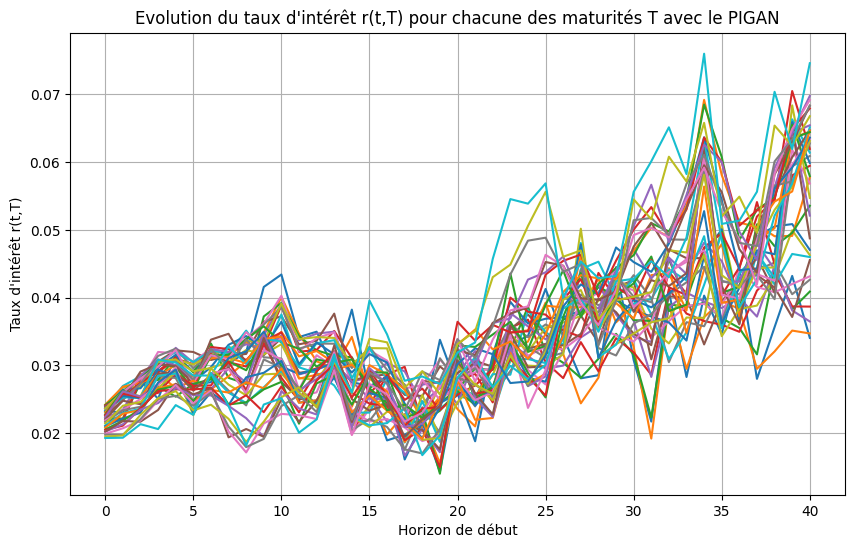

In [15]:
mean_paths = np.mean(scenarios, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title("Evolution du taux d'intérêt r(t,T) pour chacune des maturités T avec le PIGAN")
plt.xlabel('Horizon de début')
plt.ylabel("Taux d'intérêt r(t,T)")
plt.grid(True)
plt.show()